# Data formating

Training image shape:  (10000, 2)
Training image shape:  object
Image format:  [1 array([0., 0., 0., ..., 0., 0., 0.])]
Training labels shape:  (10000,)


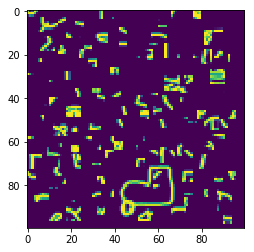

In [117]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# load training images with numpy
images_train = np.load('train_images.npy', encoding='latin1')
print("Training image shape: ",images_train.shape)
print("Training image shape: ",images_train.dtype)
print("Image format: ", (images_train[:][1]))

# load labels with numpy
train_labels = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])
print("Training labels shape: ", train_labels.shape)

#Reshaping image to 100x100
image_train1 = (images_train[32][1]).reshape(100,100)
plt.imshow(image_train1)


In [118]:
#Printing label
number_of_classes = np.unique(train_labels['Category']).size
print("Number of classes: ", number_of_classes)
# Mapping string name to class number:

class_names = np.unique(train_labels['Category'])
print(class_names)

def get_class_nb(lable):
    return np.argwhere(class_names == lable).item()

def get_class_name(indx):
    return class_names[indx]

class_nb_example = get_class_nb(train_labels[0]['Category'])
print()
print("Example: ", train_labels[0]['Category'], " is class number ", class_nb_example)
print("Example reverse:", class_nb_example, " is ", get_class_name(class_nb_example))


Number of classes:  31
[b'apple' b'empty' b'moust' b'mouth' b'mug' b'nail' b'nose' b'octag'
 b'paint' b'panda' b'parro' b'peanu' b'pear' b'penci' b'pengu' b'pillo'
 b'pinea' b'pool' b'rabbi' b'rhino' b'rifle' b'rolle' b'sailb' b'scorp'
 b'screw' b'shove' b'sink' b'skate' b'skull' b'spoon' b'squig']

Example:  b'shove'  is class number  25
Example reverse: 25  is  b'shove'


Image matrix shape:  (10000, 2)
Image format:  (10000,) will need reshaping
Image ID:  0


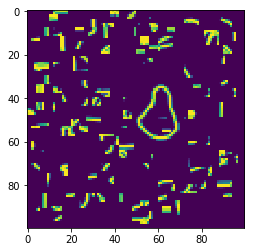

In [119]:
#Load test images with numpy
images_test = np.load('test_images.npy', encoding='latin1')
print("Image matrix shape: ", images_test.shape)
print("Image format: ", images_test[1][1].shape, "will need reshaping")

# Reshape test images
print("Image ID: ", images_test[0][0])
image_test1 = (images_test[1][1]).reshape(100,100)
plt.imshow(image_test1)

In [120]:
# Generating Validation and our own test set.
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_train, train_labels, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)


In [121]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
# debugging
# device = torch.device("cpu")
# use_cuda = False
    
print(device)

cuda


# Images are already gray scaled
* This is just interesting for futur data-ogmentation with opencv

Image value types:  float64 . Will need to convert type to uint8
(7000, 100, 100, 3)


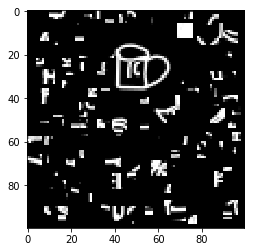

In [122]:
import cv2

print("Image value types: ", (x_train[0][1]).reshape(100,100)[0].dtype, ". Will need to convert type to uint8")

''' Steps:
1) Gray scale convert
2) Reshape and make sure we use supported type
3) For all images
'''
rgb_scale_train = np.stack(\
            [cv2.cvtColor( \
                  np.uint8(np.array(i).reshape((100, 100))), \
                  cv2.COLOR_GRAY2BGR) \
             for i in (x_train[:,1])])

print(rgb_scale_train.shape)
plt.imshow(rgb_scale_train[0])


# Creating Tensors

In [137]:
# Converting numpy array to pytorch
# End result for tensor size -> (10000, 1, 100, 100) <=> (nb examples, nb chanels, width, height)
x_train_tensor = torch.stack([torch.Tensor(np.array(i).reshape((1, 100, 100))) for i in (x_train[:,1])])
x_valid_tensor = torch.stack([torch.Tensor(np.array(i).reshape((1, 100, 100))) for i in (x_val[:,1])])
x_test_tensor = torch.stack([torch.Tensor(np.array(i).reshape((1, 100, 100))) for i in (x_test[:,1])])

train_label_converted = np.stack([get_class_nb(i) for i in y_train["Category"]])
y_train_tensor = torch.from_numpy(train_label_converted).long()

val_label_converted = np.stack([get_class_nb(i) for i in y_val["Category"]])
y_valid_tensor = torch.from_numpy(val_label_converted).long()

test_label_converted = np.stack([get_class_nb(i) for i in y_test["Category"]])
y_test_tensor = torch.from_numpy(test_label_converted).long()

print(x_train.shape, y_train.shape)
print(x_train_tensor[0].size(), y_train_tensor[0])
# size of the scratch training set TO OVERFIT
n_scratch = 64

# This parameter influences optimization
batch_size = 64
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512

indices = list(range(len(x_train)))
random.shuffle(indices)

(7000, 2) (7000,)
torch.Size([1, 100, 100]) tensor(4)


# Creating Pytoch Data Loaders

In [138]:
# Creating dataloaders
import torch.utils.data as data_utils
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)

# This is the subset of Kaggle images we want to overfit
train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
valid = data_utils.TensorDataset(x_valid_tensor, y_valid_tensor)
test  = data_utils.TensorDataset(x_test_tensor, y_test_tensor)

scratch_loader = data_utils.DataLoader(
    train,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_scratch]),
    # shuffle=True,
    num_workers=1,
    pin_memory=True # Cuda
)

train_loader = data_utils.DataLoader(
    train,
    batch_size=64,
    # The sampler is an easy way to say that we're using the elements
    shuffle=True,
    num_workers=1,
    pin_memory=True # Cuda
)

valid_loader = data_utils.DataLoader(
    valid,
    batch_size=64,
    # The sampler is an easy way to say that we're using the elements
    shuffle=True,
    num_workers=1,
    pin_memory=True # Cuda
)

test_loader = data_utils.DataLoader(
    test,
    batch_size=64,
    # The sampler is an easy way to say that we're using the elements
    shuffle=True,
    num_workers=1,
    pin_memory=True # Cuda
)

This is the shape of one batch of inputs torch.Size([64, 1, 100, 100])
This is the shape of one batch of targets torch.Size([64])
This is an image of class b'sink'


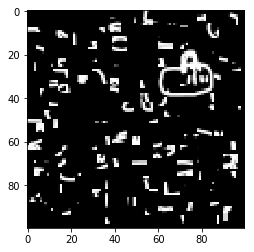

In [139]:
# Validating dataloader format
for inputs, targets in train_loader:
    print(f"This is the shape of one batch of inputs {inputs.shape}")
    print(f"This is the shape of one batch of targets {targets.shape}")
    print("This is an image of class", get_class_name(int(targets[0])))

#           " What is the meaning of each dimension?")
#     print("target", targets.shape, targets)
    img = inputs[0][0]
    plt.imshow(img, cmap='Greys_r') # We specefy the image is only gray scale values
    break

# Model definition
 **Heavely inspired from** https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/ (MIT Liscence)

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(20000, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    
    
class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7,7), padding=2, stride=1)
        self.bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc = nn.Linear(2304, 10)

    def forward(self, xin):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = self.bn(self.conv1(xin))
        x = x + F.relu(x)
        x = F.max_pool2d(x, 4) 
        
        x = x + F.relu(self.bn2(self.conv2(x)))
        # x = F.max_pool2d(x, 4) 
        
        x = self.bn3(self.conv3(x))
        x = x + F.relu(x)
        x = F.avg_pool2d(x, 4) 
        
        # x is [bs, 64, 7, 7]
        x = x.view(x.size(0), -1) # flatten
        x = F.relu(self.fc(x))
        return x

# Training

In [141]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## This method comes from the lab session number 11 of the class
def train(model, train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device) # Send data to the device
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))

In [142]:
## This method comes from the lab session number 11 of the class
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            test_size += target.size(0)

            output = model(inputs)
            loss = test_loss_fn(output, target)
            test_loss += loss
            
            pred = output.max(1, keepdim=True)[1]# [1] return s the arg max. i.e.  si idx == target, get the index of the prediction
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

### Overfitting to validate we have enough capacity

In [144]:
overfit_model = ConvNet(number_of_classes).to(device)

lr = 0.0001
optimizer = optim.Adam(overfit_model.parameters(), lr=lr)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 10):
    train(overfit_model, scratch_loader, optimizer, epoch)
    loss, acc = test(overfit_model, scratch_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/64 (0%)]	Loss: 3.463017
Test set: Average loss: 2.9973, Accuracy: 7/64 (11%)

Train Epoch: 2 [0/64 (0%)]	Loss: 2.972365
Test set: Average loss: 2.7818, Accuracy: 13/64 (20%)

Train Epoch: 3 [0/64 (0%)]	Loss: 2.667397
Test set: Average loss: 2.6073, Accuracy: 24/64 (38%)

Train Epoch: 4 [0/64 (0%)]	Loss: 2.383185
Test set: Average loss: 2.4410, Accuracy: 43/64 (67%)

Train Epoch: 5 [0/64 (0%)]	Loss: 2.089504
Test set: Average loss: 2.2769, Accuracy: 58/64 (91%)

Train Epoch: 6 [0/64 (0%)]	Loss: 1.797447
Test set: Average loss: 2.1124, Accuracy: 59/64 (92%)

Train Epoch: 7 [0/64 (0%)]	Loss: 1.522206
Test set: Average loss: 1.9448, Accuracy: 62/64 (97%)

Train Epoch: 8 [0/64 (0%)]	Loss: 1.271921
Test set: Average loss: 1.7726, Accuracy: 64/64 (100%)

Train Epoch: 9 [0/64 (0%)]	Loss: 1.048659
Test set: Average loss: 1.5962, Accuracy: 64/64 (100%)



### Training on whole training set and testing on validation set
* the model is incapable of generalising to unseen data. It's probably overfitting on the image noise. 

In [143]:
real_model = ConvNet(number_of_classes).to(device)

lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 20):
    train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/7040 (0%)]	Loss: 4.282214
Train Epoch: 1 [640/7040 (9%)]	Loss: 3.706898
Train Epoch: 1 [1280/7040 (18%)]	Loss: 3.588361
Train Epoch: 1 [1920/7040 (27%)]	Loss: 3.486059
Train Epoch: 1 [2560/7040 (36%)]	Loss: 3.526015
Train Epoch: 1 [3200/7040 (45%)]	Loss: 3.417512
Train Epoch: 1 [3840/7040 (55%)]	Loss: 3.486162
Train Epoch: 1 [4480/7040 (64%)]	Loss: 3.451602
Train Epoch: 1 [5120/7040 (73%)]	Loss: 3.493879
Train Epoch: 1 [5760/7040 (82%)]	Loss: 3.367550
Train Epoch: 1 [6400/7040 (91%)]	Loss: 3.428272
Test set: Average loss: 3.4836, Accuracy: 74/1500 (5%)

Train Epoch: 2 [0/7040 (0%)]	Loss: 3.340388
Train Epoch: 2 [640/7040 (9%)]	Loss: 3.262987
Train Epoch: 2 [1280/7040 (18%)]	Loss: 3.326237
Train Epoch: 2 [1920/7040 (27%)]	Loss: 3.226020
Train Epoch: 2 [2560/7040 (36%)]	Loss: 3.168648
Train Epoch: 2 [3200/7040 (45%)]	Loss: 3.147550
Train Epoch: 2 [3840/7040 (55%)]	Loss: 3.266174
Train Epoch: 2 [4480/7040 (64%)]	Loss: 3.221618
Train Epoch: 2 [5120/7040 (73%)]	Loss: 3.080

Train Epoch: 15 [1280/7040 (18%)]	Loss: 0.475806
Train Epoch: 15 [1920/7040 (27%)]	Loss: 0.463696
Train Epoch: 15 [2560/7040 (36%)]	Loss: 0.422264
Train Epoch: 15 [3200/7040 (45%)]	Loss: 0.469371
Train Epoch: 15 [3840/7040 (55%)]	Loss: 0.418079
Train Epoch: 15 [4480/7040 (64%)]	Loss: 0.462053
Train Epoch: 15 [5120/7040 (73%)]	Loss: 0.520111
Train Epoch: 15 [5760/7040 (82%)]	Loss: 0.471595
Train Epoch: 15 [6400/7040 (91%)]	Loss: 0.462747
Test set: Average loss: 4.1559, Accuracy: 76/1500 (5%)

Train Epoch: 16 [0/7040 (0%)]	Loss: 0.399308
Train Epoch: 16 [640/7040 (9%)]	Loss: 0.373081
Train Epoch: 16 [1280/7040 (18%)]	Loss: 0.406813
Train Epoch: 16 [1920/7040 (27%)]	Loss: 0.375897
Train Epoch: 16 [2560/7040 (36%)]	Loss: 0.431394
Train Epoch: 16 [3200/7040 (45%)]	Loss: 0.358493
Train Epoch: 16 [3840/7040 (55%)]	Loss: 0.366060
Train Epoch: 16 [4480/7040 (64%)]	Loss: 0.375568
Train Epoch: 16 [5120/7040 (73%)]	Loss: 0.426138
Train Epoch: 16 [5760/7040 (82%)]	Loss: 0.399527
Train Epoch: 16 [64

# Output test results